# Introduction

This notebook implements a text mining pipeline for analyzing Italian job advertisements, addressing **Text Classification** and **Topic Modeling** tasks.

| Aspect | Approach |
|--------|----------|
| **Text Representation** | TF-IDF vs multi-sentence-BERTino (768-dim) |
| **Preprocessing** | Minimal for embeddings, aggressive for topic modeling |
| **Classification** | Logistic Regression, Random Forest, SGDClassifier |
| **Topic Modeling** | LSA, LDA, HDP, BERTopic |

## Dataset Description

*[Your observations here]*

---

# PART 1: SETUP

In [1]:
# Uncomment if needed
# !pip install -r requirements.txt

## 1.1 Imports and Configuration

In [ ]:
import os
import re
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sentence_transformers import SentenceTransformer

import tmes_functions as tmes

try:
    import gensim
    from gensim import corpora
    from gensim.models import HdpModel, CoherenceModel
    from gensim.models.ldamulticore import LdaMulticore
    GENSIM_AVAILABLE = True
except ImportError:
    GENSIM_AVAILABLE = False

try:
    from bertopic import BERTopic
    from bertopic.representation import KeyBERTInspired
    BERTOPIC_AVAILABLE = True
except ImportError:
    BERTOPIC_AVAILABLE = False

try:
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis
    pyLDAvis.enable_notebook()
    PYLDAVIS_AVAILABLE = True
except ImportError:
    PYLDAVIS_AVAILABLE = False

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

try:
    from hdbscan import HDBSCAN
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

Device: cpu


In [ ]:
FORCE_REGENERATE_DATA = False
FORCE_REGENERATE_EMBEDDINGS = False
FORCE_REGENERATE_CLASSIFIERS = False
FORCE_REGENERATE_TOPICS = False

DATA_PATH = "sample_skill_extraction.csv"
TEXT_COL = "description"
LABEL_COL = "found_label"
TEST_SIZE = 0.3
TRAIN_SIZE = 1 - TEST_SIZE

EMBEDDING_MODEL_NAME = "nickprock/multi-sentence-BERTino"
N_TOPICS = None 

OUTPUT_DIR = "output"
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
CACHE_DIR = os.path.join(OUTPUT_DIR, "cache")

for d in [OUTPUT_DIR, MODELS_DIR, PLOTS_DIR, RESULTS_DIR, CACHE_DIR]:
    os.makedirs(d, exist_ok=True)

## 1.2 Stopwords Configuration

In [4]:
NLTK_STOPWORDS = set(stopwords.words('italian')) | set(stopwords.words('english'))

ITALIAN_JOB_STOPWORDS = {
    'lavoro', 'azienda', 'società', 'candidato', 'candidata', 'candidati',
    'esperienza', 'richiesta', 'richiesto', 'richiesti',
    'contratto', 'tempo', 'determinato', 'indeterminato',
    'full', 'time', 'part', 'sede', 'orario',
    'offerta', 'posizione', 'ruolo', 'figura', 'profilo',
    'inserimento', 'assunzione', 'selezione',
    'inviare', 'cv', 'curriculum', 'candidatura',
    'randstad', 'adecco', 'manpower', 'gigroup', 'synergie', 'umana',
    'www', 'http', 'https', 'com', 'it', 'html', 'nbsp', 'amp',
    'span', 'div', 'class', 'style', 'href',
    'privacy', 'informativa', 'consenso', 'dati', 'personali',
    'dlgs', 'lgs', 'art', 'legge', 'decreto', 'sensi', 'norma',
    'aut', 'min', 'prot', 'reg'
}

ALL_STOPWORDS = NLTK_STOPWORDS | ITALIAN_JOB_STOPWORDS
print(f"Total stopwords: {len(ALL_STOPWORDS)}")

Total stopwords: 536


---

# PART 2: EXECUTION

## 2.1 Data Loading

In [ ]:
df_leakage = None if FORCE_REGENERATE_DATA else tmes.load_cache("df_leakage")
df_standard = None if FORCE_REGENERATE_DATA else tmes.load_cache("df_standard")
label_encoder = None if FORCE_REGENERATE_DATA else tmes.load_cache("label_encoder")

  ✓ Loaded from cache: df_leakage
  ✓ Loaded from cache: df_standard
  ✓ Loaded from cache: label_encoder


In [ ]:
if df_leakage is None or df_standard is None or label_encoder is None:
    df = pd.read_csv(
        DATA_PATH,
        usecols=[TEXT_COL, LABEL_COL],
        sep=",",
        quotechar='"',
        engine="python",
        encoding="utf-8",
        on_bad_lines="warn"
    )
    print(f"Raw dataset: {df.shape}")
    
    initial_len = len(df)
    df = df.drop_duplicates(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    print(f"After cleaning: {len(df)} samples (removed {initial_len - len(df)} duplicates/NaN)")
    print(f"Classes: {df[LABEL_COL].nunique()}")
    
    print("\nCreating two preprocessing versions...")
    
    df['clean_text_leakage'] = df.apply(
        lambda x: tmes.clean_text_minimal(x[TEXT_COL], x[LABEL_COL]), 
        axis=1
    )
    
    df['clean_text_standard'] = df[TEXT_COL].apply(
        lambda x: tmes.clean_text_minimal(x)  # No label_to_remove
    )
    
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df[LABEL_COL].astype(str))
    
    df_leakage, df_leakage_test = train_test_split(
        df[[LABEL_COL, 'clean_text_leakage', 'label_encoded']].rename(columns={'clean_text_leakage': 'clean_text'}),
        test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label_encoded']
    )
    
    df_standard, df_standard_test = train_test_split(
        df[[LABEL_COL, 'clean_text_standard', 'label_encoded']].rename(columns={'clean_text_standard': 'clean_text'}),
        test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label_encoded']
    )
    
    df_leakage = df_leakage.reset_index(drop=True)
    df_leakage_test = df_leakage_test.reset_index(drop=True)
    df_standard = df_standard.reset_index(drop=True)
    df_standard_test = df_standard_test.reset_index(drop=True)
    
    tmes.save_cache(df_leakage, "df_leakage")
    tmes.save_cache(df_leakage_test, "df_leakage_test")
    tmes.save_cache(df_standard, "df_standard")
    tmes.save_cache(df_standard_test, "df_standard_test")
    tmes.save_cache(label_encoder, "label_encoder")
else:
    df_leakage_test = tmes.load_cache("df_leakage_test")
    df_standard_test = tmes.load_cache("df_standard_test")

print(f"\nDataset summary:")
print(f"  Train: {len(df_leakage)}, Test: {len(df_leakage_test)}, Classes: {len(label_encoder.classes_)}")

  ✓ Loaded from cache: df_leakage_test
  ✓ Loaded from cache: df_standard_test

Dataset summary:
  Train: 19691, Test: 8439, Classes: 615


In [ ]:
import textwrap
from IPython.display import display, HTML

def show_leakage_example(df_original, text_col, label_col, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(df_original))
    
    row = df_original.iloc[idx]
    original_text = row[text_col]
    label = row[label_col]
    
    pattern = re.compile(f'({re.escape(label)})', re.IGNORECASE)
    highlighted = pattern.sub(
        r'<span style="text-decoration: underline wavy red; font-weight: bold;">[\1]</span>', 
        original_text
    )
    
    cleaned = tmes.clean_text_minimal(original_text, label)
    
    html = f"""
    <div style="font-family: monospace; max-width: 800px;">
        <h3>Leakage Prevention Example (Index: {idx})</h3>
        <p><strong>Label:</strong> <code>{label}</code></p>
        
        <h4>Original Text (label marked with [brackets] and underline):</h4>
        <div style="padding: 10px; border: 1px solid currentColor; border-radius: 5px; margin-bottom: 15px;">
            {textwrap.shorten(highlighted, width=1500, placeholder='...')}
        </div>
        
        <h4>After Leakage Prevention:</h4>
        <div style="padding: 10px; border: 1px dashed currentColor; border-radius: 5px;">
            {textwrap.shorten(cleaned, width=1500, placeholder='...')}
        </div>
    </div>
    """
    display(HTML(html))

df_original = pd.read_csv(DATA_PATH, usecols=[TEXT_COL, LABEL_COL], sep=",", quotechar='"', 
                          engine="python", encoding="utf-8", on_bad_lines="warn")
df_original = df_original.dropna().reset_index(drop=True)

lista = [14453, 24358, 21406]

for _ in range(3):
    show_leakage_example(df_original, TEXT_COL, LABEL_COL, lista[_])
    print("\n" + "="*80 + "\n")

In [8]:
# Prepare data arrays
y_train_enc = label_encoder.transform(df_leakage[LABEL_COL].astype(str))
y_test_enc = label_encoder.transform(df_leakage_test[LABEL_COL].astype(str))

# With leakage prevention
X_train_leakage = df_leakage['clean_text'].tolist()
X_test_leakage = df_leakage_test['clean_text'].tolist()

# Without leakage prevention (standard)
X_train_standard = df_standard['clean_text'].tolist()
X_test_standard = df_standard_test['clean_text'].tolist()

## 2.2 Embedding Generation

Generate embeddings for both versions (with and without leakage prevention).

In [9]:
# Try to load from cache
train_emb_leakage = None if FORCE_REGENERATE_EMBEDDINGS else tmes.load_embeddings_cache("train_emb_leakage")
test_emb_leakage = None if FORCE_REGENERATE_EMBEDDINGS else tmes.load_embeddings_cache("test_emb_leakage")
train_emb_standard = None if FORCE_REGENERATE_EMBEDDINGS else tmes.load_embeddings_cache("train_emb_standard")
test_emb_standard = None if FORCE_REGENERATE_EMBEDDINGS else tmes.load_embeddings_cache("test_emb_standard")

  ✓ Loaded embeddings from cache: train_emb_leakage
  ✓ Loaded embeddings from cache: test_emb_leakage
  ✓ Loaded embeddings from cache: train_emb_standard
  ✓ Loaded embeddings from cache: test_emb_standard


In [10]:
need_embeddings = (
    train_emb_leakage is None or test_emb_leakage is None or
    train_emb_standard is None or test_emb_standard is None
)

if need_embeddings:
    print(f"Loading model: {EMBEDDING_MODEL_NAME}")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=DEVICE)
    
    # WITH leakage prevention
    if train_emb_leakage is None:
        print("Generating embeddings (with leakage prevention)...")
        train_emb_leakage = embedding_model.encode(
            X_train_leakage, batch_size=32, show_progress_bar=True,
            convert_to_numpy=True, normalize_embeddings=True
        )
        test_emb_leakage = embedding_model.encode(
            X_test_leakage, batch_size=32, show_progress_bar=True,
            convert_to_numpy=True, normalize_embeddings=True
        )
        tmes.save_embeddings_cache(train_emb_leakage, "train_emb_leakage")
        tmes.save_embeddings_cache(test_emb_leakage, "test_emb_leakage")
    
    # WITHOUT leakage prevention
    if train_emb_standard is None:
        print("Generating embeddings (without leakage prevention)...")
        train_emb_standard = embedding_model.encode(
            X_train_standard, batch_size=32, show_progress_bar=True,
            convert_to_numpy=True, normalize_embeddings=True
        )
        test_emb_standard = embedding_model.encode(
            X_test_standard, batch_size=32, show_progress_bar=True,
            convert_to_numpy=True, normalize_embeddings=True
        )
        tmes.save_embeddings_cache(train_emb_standard, "train_emb_standard")
        tmes.save_embeddings_cache(test_emb_standard, "test_emb_standard")
    
    del embedding_model
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

print(f"Embeddings shape: Train={train_emb_leakage.shape}, Test={test_emb_leakage.shape}")

Embeddings shape: Train=(19691, 768), Test=(8439, 768)


## 2.3 Text Classification

Comparative evaluation:
- **Representations**: TF-IDF vs BERTino
- **Leakage**: With vs Without prevention
- **Classifiers**: Logistic Regression, Random Forest, SGDClassifier

In [11]:
classification_results = []
all_predictions = {}

classifiers_cached = (
    tmes.cache_exists("classification_results") and
    not FORCE_REGENERATE_CLASSIFIERS
)

In [12]:
if classifiers_cached:
    classification_results = tmes.load_cache("classification_results")
    all_predictions = tmes.load_cache("all_predictions")
else:
    # Define classifiers
    def get_classifiers():
        return {
            'LogReg': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1),
            'RF': RandomForestClassifier(n_estimators=200, min_samples_split=5, random_state=RANDOM_STATE, n_jobs=-1),
            'SGD': SGDClassifier(loss='log_loss', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1, early_stopping=True)
        }
    
    # ========================================================================
    # TF-IDF REPRESENTATION
    # ========================================================================
    print("=== TF-IDF ===")
    
    # TF-IDF with leakage prevention
    print("\n[With Leakage Prevention]")
    tfidf_leakage = TfidfVectorizer(max_features=5000)
    X_train_tfidf_leakage = tfidf_leakage.fit_transform(X_train_leakage)
    X_test_tfidf_leakage = tfidf_leakage.transform(X_test_leakage)
    
    for name, clf in get_classifiers().items():
        start = time.time()
        clf.fit(X_train_tfidf_leakage, y_train_enc)
        train_time = time.time() - start
        y_pred = clf.predict(X_test_tfidf_leakage)
        
        classification_results.append({
            'model': f'TF-IDF + {name}',
            'leakage_prevention': 'Yes',
            'representation': 'TF-IDF',
            'accuracy': accuracy_score(y_test_enc, y_pred),
            'f1_weighted': f1_score(y_test_enc, y_pred, average='weighted'),
            'f1_macro': f1_score(y_test_enc, y_pred, average='macro'),
            'train_time_sec': train_time
        })
        all_predictions[f'TF-IDF_{name}_leakage'] = y_pred
        print(f"  {name}: F1={classification_results[-1]['f1_weighted']:.4f}, Time={train_time:.1f}s")
    
    # TF-IDF without leakage prevention
    print("\n[Without Leakage Prevention]")
    tfidf_standard = TfidfVectorizer(max_features=5000, stop_words=list(ALL_STOPWORDS), analyzer='word')
    X_train_tfidf_standard = tfidf_standard.fit_transform(X_train_standard)
    X_test_tfidf_standard = tfidf_standard.transform(X_test_standard)
    
    for name, clf in get_classifiers().items():
        start = time.time()
        clf.fit(X_train_tfidf_standard, y_train_enc)
        train_time = time.time() - start
        y_pred = clf.predict(X_test_tfidf_standard)
        
        classification_results.append({
            'model': f'TF-IDF + {name}',
            'leakage_prevention': 'No',
            'representation': 'TF-IDF',
            'accuracy': accuracy_score(y_test_enc, y_pred),
            'f1_weighted': f1_score(y_test_enc, y_pred, average='weighted'),
            'f1_macro': f1_score(y_test_enc, y_pred, average='macro'),
            'train_time_sec': train_time
        })
        all_predictions[f'TF-IDF_{name}_standard'] = y_pred
        print(f"  {name}: F1={classification_results[-1]['f1_weighted']:.4f}, Time={train_time:.1f}s")
    
    # Save TF-IDF vectorizers for visualization
    tmes.save_cache(tfidf_leakage, "tfidf_leakage")
    tmes.save_cache(tfidf_standard, "tfidf_standard")
    tmes.save_cache(X_train_tfidf_leakage, "X_train_tfidf_leakage")
    tmes.save_cache(X_train_tfidf_standard, "X_train_tfidf_standard")
    
    # ========================================================================
    # BERTino EMBEDDINGS
    # ========================================================================
    print("\n=== BERTino ===")
    
    # BERTino with leakage prevention
    print("\n[With Leakage Prevention]")
    for name, clf in get_classifiers().items():
        start = time.time()
        clf.fit(train_emb_leakage, y_train_enc)
        train_time = time.time() - start
        y_pred = clf.predict(test_emb_leakage)
        
        classification_results.append({
            'model': f'BERTino + {name}',
            'leakage_prevention': 'Yes',
            'representation': 'BERTino',
            'accuracy': accuracy_score(y_test_enc, y_pred),
            'f1_weighted': f1_score(y_test_enc, y_pred, average='weighted'),
            'f1_macro': f1_score(y_test_enc, y_pred, average='macro'),
            'train_time_sec': train_time
        })
        all_predictions[f'BERTino_{name}_leakage'] = y_pred
        print(f"  {name}: F1={classification_results[-1]['f1_weighted']:.4f}, Time={train_time:.1f}s")
    
    # BERTino without leakage prevention
    print("\n[Without Leakage Prevention]")
    for name, clf in get_classifiers().items():
        start = time.time()
        clf.fit(train_emb_standard, y_train_enc)
        train_time = time.time() - start
        y_pred = clf.predict(test_emb_standard)
        
        classification_results.append({
            'model': f'BERTino + {name}',
            'leakage_prevention': 'No',
            'representation': 'BERTino',
            'accuracy': accuracy_score(y_test_enc, y_pred),
            'f1_weighted': f1_score(y_test_enc, y_pred, average='weighted'),
            'f1_macro': f1_score(y_test_enc, y_pred, average='macro'),
            'train_time_sec': train_time
        })
        all_predictions[f'BERTino_{name}_standard'] = y_pred
        print(f"  {name}: F1={classification_results[-1]['f1_weighted']:.4f}, Time={train_time:.1f}s")
    
    # Save results
    tmes.save_cache(classification_results, "classification_results")
    tmes.save_cache(all_predictions, "all_predictions")

=== TF-IDF ===

[With Leakage Prevention]
  LogReg: F1=0.5163, Time=156.8s
  RF: F1=0.6583, Time=440.8s
  SGD: F1=0.4770, Time=30.2s

[Without Leakage Prevention]
  LogReg: F1=0.5404, Time=152.0s
  RF: F1=0.6670, Time=392.5s
  SGD: F1=0.4968, Time=32.4s
  ✓ Cached: tfidf_leakage
  ✓ Cached: tfidf_standard
  ✓ Cached: X_train_tfidf_leakage
  ✓ Cached: X_train_tfidf_standard

=== BERTino ===

[With Leakage Prevention]
  LogReg: F1=0.3102, Time=231.0s
  RF: F1=0.5807, Time=2055.6s
  SGD: F1=0.2152, Time=16.1s

[Without Leakage Prevention]
  LogReg: F1=0.3190, Time=36.1s
  RF: F1=0.5849, Time=688.3s
  SGD: F1=0.2217, Time=13.2s
  ✓ Cached: classification_results
  ✓ Cached: all_predictions


In [13]:
# Results summary
clf_df = pd.DataFrame(classification_results)
clf_df = clf_df.sort_values(['representation', 'leakage_prevention', 'f1_weighted'], ascending=[True, True, False])

print("\nClassification Results:")
print(clf_df[['model', 'leakage_prevention', 'accuracy', 'f1_weighted', 'train_time_sec']].round(4).to_string(index=False))

clf_df.to_csv(os.path.join(RESULTS_DIR, "classification_results.csv"), index=False)

# Leakage impact analysis
print("\n--- Leakage Prevention Impact ---")
for rep in ['TF-IDF', 'BERTino']:
    for clf_name in ['LogReg', 'RF', 'SGD']:
        with_leak = clf_df[(clf_df['model'].str.contains(clf_name)) & 
                          (clf_df['representation'] == rep) & 
                          (clf_df['leakage_prevention'] == 'Yes')]['f1_weighted'].values[0]
        without_leak = clf_df[(clf_df['model'].str.contains(clf_name)) & 
                              (clf_df['representation'] == rep) & 
                              (clf_df['leakage_prevention'] == 'No')]['f1_weighted'].values[0]
        diff = without_leak - with_leak
        print(f"  {rep} + {clf_name}: {diff:+.4f} (No leakage prev. - With leakage prev.)")


Classification Results:
           model leakage_prevention  accuracy  f1_weighted  train_time_sec
    BERTino + RF                 No    0.5901       0.5849        688.2912
BERTino + LogReg                 No    0.3529       0.3190         36.0571
   BERTino + SGD                 No    0.2625       0.2217         13.2322
    BERTino + RF                Yes    0.5864       0.5807       2055.6228
BERTino + LogReg                Yes    0.3448       0.3102        230.9908
   BERTino + SGD                Yes    0.2562       0.2152         16.0562
     TF-IDF + RF                 No    0.6713       0.6670        392.4781
 TF-IDF + LogReg                 No    0.5490       0.5404        152.0346
    TF-IDF + SGD                 No    0.5097       0.4968         32.3767
     TF-IDF + RF                Yes    0.6618       0.6583        440.8084
 TF-IDF + LogReg                Yes    0.5226       0.5163        156.7798
    TF-IDF + SGD                Yes    0.4850       0.4770         30.1503


## 2.4 Representation Visualization (UMAP)

Compare the embedding spaces across all representations.

In [14]:
if UMAP_AVAILABLE:
    # Sample for visualization
    max_points = 5000
    all_emb_leakage = np.vstack([train_emb_leakage, test_emb_leakage])
    all_emb_standard = np.vstack([train_emb_standard, test_emb_standard])
    all_labels = np.concatenate([y_train_enc, y_test_enc])
    
    if len(all_emb_leakage) > max_points:
        sample_idx = np.random.choice(len(all_emb_leakage), max_points, replace=False)
    else:
        sample_idx = np.arange(len(all_emb_leakage))
    
    labels_sample = all_labels[sample_idx]
    
    # Load TF-IDF matrices if needed
    X_train_tfidf_leakage = tmes.load_cache("X_train_tfidf_leakage")
    X_train_tfidf_standard = tmes.load_cache("X_train_tfidf_standard")
    
    # Prepare data for 4 subplots
    print("Computing UMAP projections...")
    
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=RANDOM_STATE)
    
    # BERTino embeddings
    emb_leakage_sample = all_emb_leakage[sample_idx]
    emb_standard_sample = all_emb_standard[sample_idx]
    
    umap_bertino_leakage = reducer.fit_transform(emb_leakage_sample)
    umap_bertino_standard = reducer.fit_transform(emb_standard_sample)
    
    # TF-IDF (need to reduce dimensionality first with SVD, then UMAP)
    # Combine train matrices and sample
    tfidf_leakage_dense = X_train_tfidf_leakage.toarray()
    tfidf_standard_dense = X_train_tfidf_standard.toarray()
    
    # Sample from train only (since we only have train TF-IDF cached)
    train_sample_idx = sample_idx[sample_idx < len(train_emb_leakage)]
    if len(train_sample_idx) < max_points:
        train_sample_idx = np.random.choice(len(tfidf_leakage_dense), min(max_points, len(tfidf_leakage_dense)), replace=False)
    
    tfidf_leakage_sample = tfidf_leakage_dense[train_sample_idx]
    tfidf_standard_sample = tfidf_standard_dense[train_sample_idx]
    labels_tfidf_sample = y_train_enc[train_sample_idx]
    
    # SVD + UMAP for TF-IDF
    svd = TruncatedSVD(n_components=50, random_state=RANDOM_STATE)
    tfidf_leakage_svd = svd.fit_transform(tfidf_leakage_sample)
    tfidf_standard_svd = svd.fit_transform(tfidf_standard_sample)
    
    reducer_tfidf = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=RANDOM_STATE)
    umap_tfidf_leakage = reducer_tfidf.fit_transform(tfidf_leakage_svd)
    umap_tfidf_standard = reducer_tfidf.fit_transform(tfidf_standard_svd)
    
    print("UMAP projections computed.")

  ✓ Loaded from cache: X_train_tfidf_leakage
  ✓ Loaded from cache: X_train_tfidf_standard
Computing UMAP projections...
UMAP projections computed.


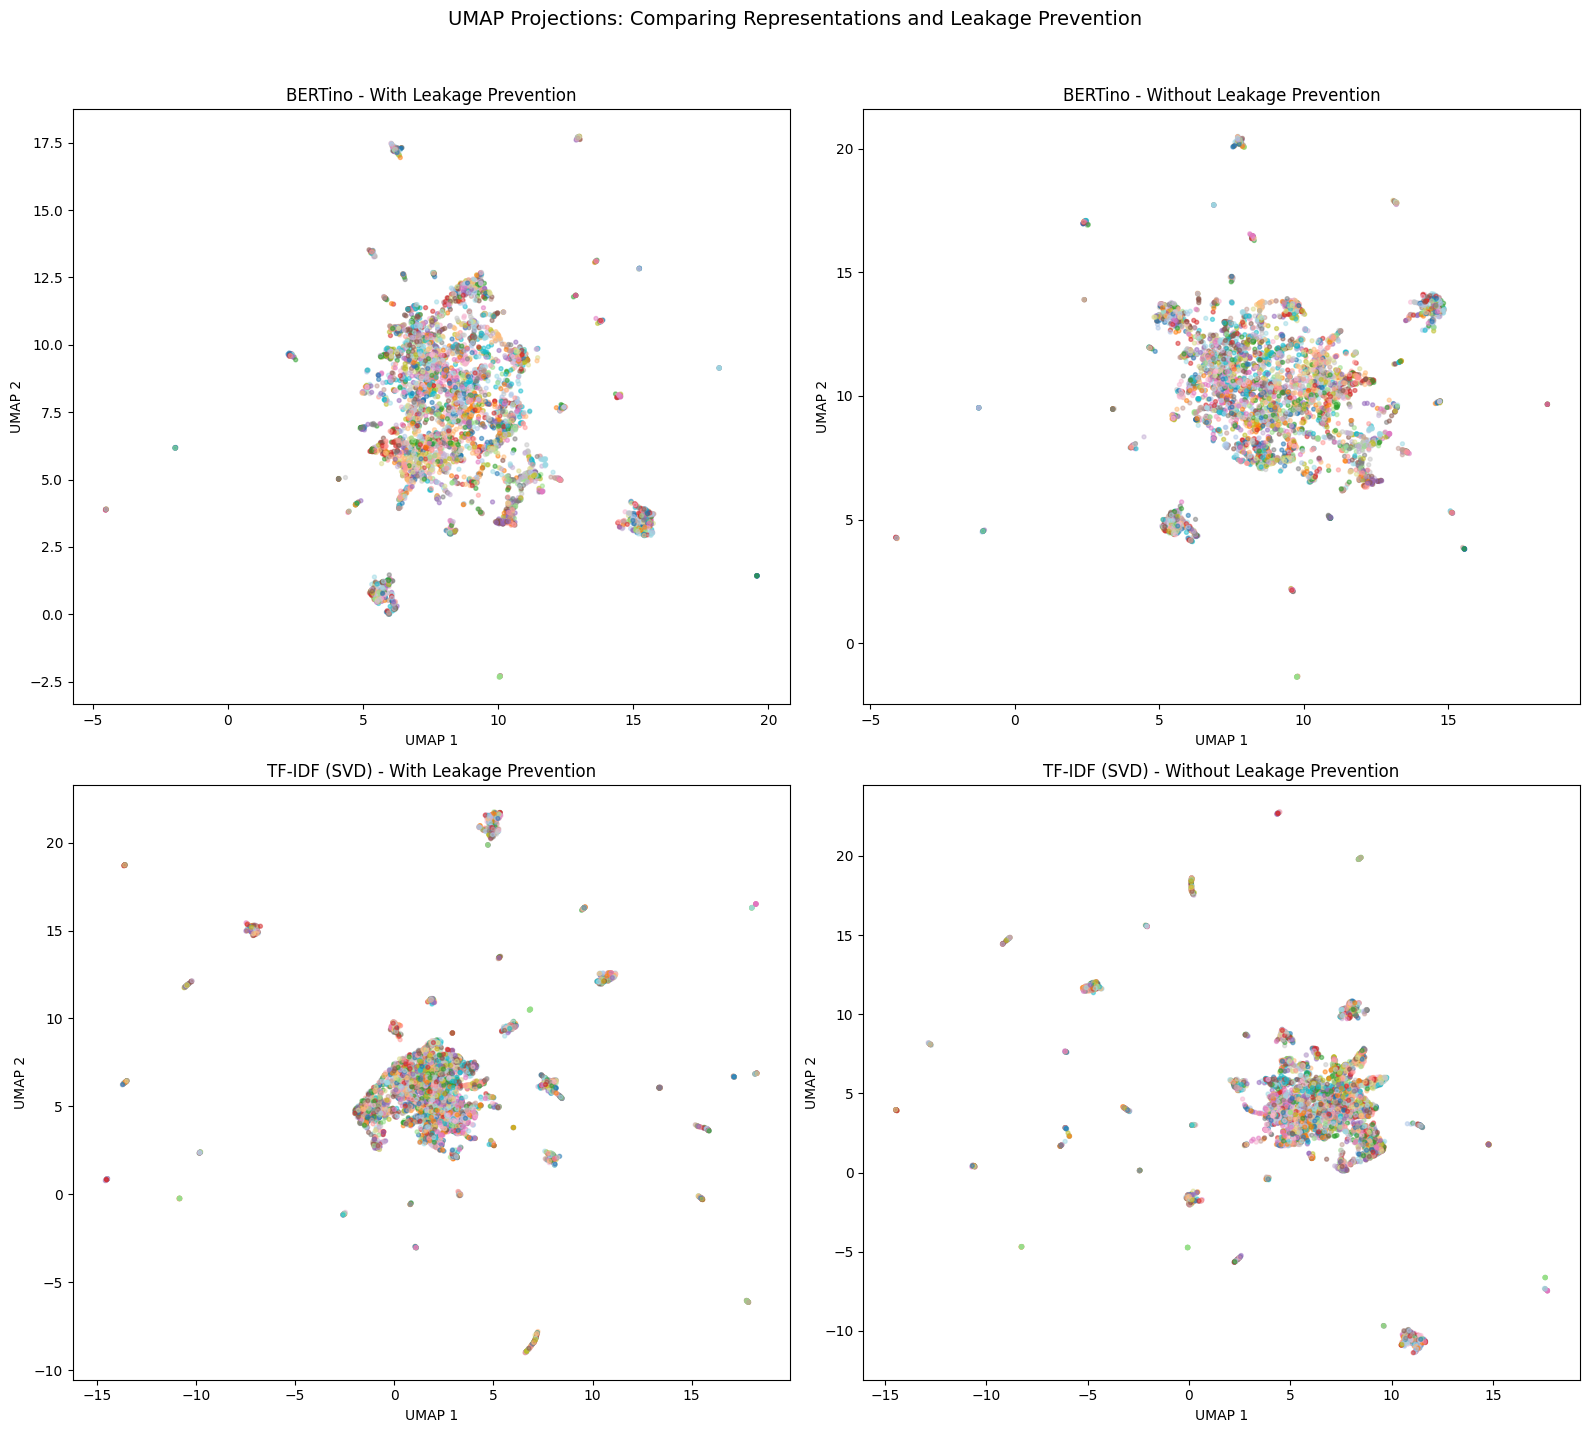

In [15]:
if UMAP_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Top row: BERTino embeddings
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(umap_bertino_leakage[:, 0], umap_bertino_leakage[:, 1],
                           c=labels_sample, cmap='tab20', alpha=0.5, s=8)
    ax1.set_title('BERTino - With Leakage Prevention', fontsize=12)
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(umap_bertino_standard[:, 0], umap_bertino_standard[:, 1],
                           c=labels_sample, cmap='tab20', alpha=0.5, s=8)
    ax2.set_title('BERTino - Without Leakage Prevention', fontsize=12)
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    
    # Bottom row: TF-IDF
    ax3 = axes[1, 0]
    scatter3 = ax3.scatter(umap_tfidf_leakage[:, 0], umap_tfidf_leakage[:, 1],
                           c=labels_tfidf_sample, cmap='tab20', alpha=0.5, s=8)
    ax3.set_title('TF-IDF (SVD) - With Leakage Prevention', fontsize=12)
    ax3.set_xlabel('UMAP 1')
    ax3.set_ylabel('UMAP 2')
    
    ax4 = axes[1, 1]
    scatter4 = ax4.scatter(umap_tfidf_standard[:, 0], umap_tfidf_standard[:, 1],
                           c=labels_tfidf_sample, cmap='tab20', alpha=0.5, s=8)
    ax4.set_title('TF-IDF (SVD) - Without Leakage Prevention', fontsize=12)
    ax4.set_xlabel('UMAP 1')
    ax4.set_ylabel('UMAP 2')
    
    plt.suptitle('UMAP Projections: Comparing Representations and Leakage Prevention', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "umap_comparison_4panel.png"), dpi=300, bbox_inches='tight')
    plt.show()

## 2.5 Error Analysis

In [16]:
# Best model from leakage-prevented classification
best_leakage = clf_df[clf_df['leakage_prevention'] == 'Yes'].sort_values('f1_weighted', ascending=False).iloc[0]
best_key = f"{best_leakage['representation']}_{best_leakage['model'].split(' + ')[1]}_leakage"
y_pred_best = all_predictions.get(best_key, list(all_predictions.values())[0])

# Confusion matrix for top classes
n_classes = len(label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred_best)

# Find most confused pairs
confused_pairs = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm[i, j] > 2:
            confused_pairs.append({
                'true': label_encoder.classes_[i],
                'pred': label_encoder.classes_[j],
                'count': cm[i, j]
            })

confused_df = pd.DataFrame(confused_pairs).sort_values('count', ascending=False)
print(f"Top 10 Most Confused Pairs (Best model: {best_leakage['model']}):")
for _, row in confused_df.head(10).iterrows():
    print(f"  '{row['true'][:40]}' → '{row['pred'][:40]}': {row['count']}")

Top 10 Most Confused Pairs (Best model: TF-IDF + RF):
  'autista privato/autista privata' → 'autista di carro funebre': 7
  'ingegnere ambientale' → 'consulente ecologico/consulente ecologic': 6
  'coreografo/coreografa' → 'ballerino/ballerina': 6
  'ballerino/ballerina' → 'coreografo/coreografa': 6
  'architetto di interni/architetta di inte' → 'assistente direttore di scena/assistente': 6
  'addetto stireria/addetta stireria' → 'responsabile di lavanderia e lavasecco': 5
  'veterinario generalista' → 'veterinario specialista': 5
  'montatore aeronautico/montatrice aeronau' → 'montatore di motocicli/montatrice di mot': 5
  'carrozziere costruttore di veicoli/carro' → 'verniciatore navale/verniciatrice navale': 5
  'addetto alla pulizia di tappeti e altri ' → 'addetto alle pulizie dei vagoni ferrovia': 5


## 2.6 Topic Modeling

Using texts with leakage prevention for topic modeling.

In [ ]:
all_texts = X_train_leakage + X_test_leakage
all_texts_topics = [tmes.clean_text_for_topics(t, ALL_STOPWORDS) for t in tqdm(all_texts, desc="Cleaning")]
texts_tokenized = tmes.tokenize_for_gensim(all_texts_topics)

print(f"Documents for topic modeling: {len(texts_tokenized)}")

Cleaning:   0%|          | 0/28130 [00:00<?, ?it/s]

Documents for topic modeling: 28129


In [ ]:
dictionary = None if FORCE_REGENERATE_TOPICS else tmes.load_cache("gensim_dictionary")
corpus = None if FORCE_REGENERATE_TOPICS else tmes.load_cache("gensim_corpus")

if dictionary is None or corpus is None:
    dictionary = corpora.Dictionary(texts_tokenized)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts_tokenized]
    tmes.save_cache(dictionary, "gensim_dictionary")
    tmes.save_cache(corpus, "gensim_corpus")

print(f"Vocabulary: {len(dictionary)} terms, Corpus: {len(corpus)} documents")

  ✓ Loaded from cache: gensim_dictionary
  ✓ Loaded from cache: gensim_corpus
Vocabulary: 19317 terms, Corpus: 28129 documents


In [ ]:
hdp_model = None if FORCE_REGENERATE_TOPICS else tmes.load_cache("hdp_model")
hdp_num_topics = None if FORCE_REGENERATE_TOPICS else tmes.load_cache("hdp_num_topics")

if hdp_model is None and GENSIM_AVAILABLE:
    print("Training HDP...")
    hdp_model = HdpModel(corpus=corpus, id2word=dictionary, random_state=RANDOM_STATE)
    
    topic_weights = []
    for i in range(30):
        try:
            topic = hdp_model.show_topic(i, topn=5)
            if topic:
                weight = sum(w for _, w in topic)
                topic_weights.append((i, weight))
        except:
            break
    
    significant_topics = [t for t, w in topic_weights if w > 0.01]
    hdp_num_topics = max(5, min(20, len(significant_topics) if significant_topics else 10))
    
    tmes.save_cache(hdp_model, "hdp_model")
    tmes.save_cache(hdp_num_topics, "hdp_num_topics")

if N_TOPICS is None:
    N_TOPICS = hdp_num_topics if hdp_num_topics else 10

print(f"Number of topics: {N_TOPICS}")

  ✓ Loaded from cache: hdp_model
  ✓ Loaded from cache: hdp_num_topics
Number of topics: 20


In [ ]:
topic_metrics = {}

print("Training LSA...")
tfidf_topic = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.7, stop_words=list(ALL_STOPWORDS))
tfidf_matrix = tfidf_topic.fit_transform(all_texts_topics)
feature_names = tfidf_topic.get_feature_names_out()

lsa_model = TruncatedSVD(n_components=N_TOPICS, random_state=RANDOM_STATE)
lsa_model.fit(tfidf_matrix)

lsa_topics = [[feature_names[i] for i in np.argsort(np.abs(comp))[::-1][:10]] for comp in lsa_model.components_]

try:
    coh_lsa = CoherenceModel(topics=lsa_topics, texts=texts_tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
except:
    coh_lsa = None
try:
    perp_lsa = tmes.calculate_perplexity(lsa_model, corpus)
except:
    perp_lsa = None
div_lsa = tmes.calculate_topic_diversity(lsa_topics)
topic_metrics['LSA'] = {'coherence': coh_lsa, 'diversity': div_lsa, 'perplexity' : perp_lsa}
print(f"  LSA: Coherence={round(coh_lsa,3)}, Perplexity={perp_lsa}, Diversity={round(div_lsa, 3)}")

Training LSA...
  LSA: Coherence=0.54, Perplexity=None, Diversity=0.555


In [ ]:
lda_model = None if FORCE_REGENERATE_TOPICS else tmes.load_cache("lda_model")

if lda_model is None and GENSIM_AVAILABLE:
    print("Training LDA...")
    lda_model = LdaMulticore(
        corpus=corpus, id2word=dictionary, num_topics=N_TOPICS,
        random_state=RANDOM_STATE, chunksize=100, passes=10, workers=4
    )
    tmes.save_cache(lda_model, "lda_model")

if lda_model:
    lda_topics = tmes.get_topic_words(lda_model)
    coh_lda = tmes.calculate_coherence(lda_model, corpus, dictionary, texts_tokenized)
    perp_lda = tmes.calculate_perplexity(lda_model, corpus)
    div_lda = tmes.calculate_topic_diversity(lda_topics)
    topic_metrics['LDA'] = {'coherence': coh_lda, 'perplexity': perp_lda, 'diversity': div_lda}
    print(f"  LDA: Coherence={round(coh_lda, 3)}, Perplexity={perp_lda}, Diversity={round(div_lda, 3)}")

  ✓ Loaded from cache: lda_model
  LDA: Coherence=0.624, Perplexity=-8.5201992893843, Diversity=0.79


In [ ]:
if hdp_model:
    hdp_topics = []
    for i in range(N_TOPICS):
        try:
            topic = hdp_model.show_topic(i, topn=10)
            if topic:
                hdp_topics.append([w for w, _ in topic])
        except:
            break
    
    if hdp_topics:
        try:
            coh_hdp = CoherenceModel(topics=hdp_topics, texts=texts_tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
        except:
            coh_hdp = None
        try:
            div_hdp = tmes.calculate_topic_diversity(hdp_topics)
        except:
            div_hdp = None
        try:
            hdpldam = hdp_model.suggested_lda_model()
            perp_hdp = hdpldam.log_perplexity(corpus)
        except:
            perp_hdp = None
        topic_metrics['HDP'] = {'coherence': coh_hdp, 'diversity': div_hdp, 'perplexity' : perp_hdp}
        print(f"  HDP: Coherence={round(coh_hdp,3)}, Perplexity={perp_hdp}, Diversity={round(div_hdp,3)}")

  HDP: Coherence=0.649, Perplexity=-14.012722885828707, Diversity=0.635


In [ ]:
if BERTOPIC_AVAILABLE and UMAP_AVAILABLE and HDBSCAN_AVAILABLE:
    bertopic_model = None if FORCE_REGENERATE_TOPICS else tmes.load_cache("bertopic_model")
    
    if bertopic_model is None:
        print("Training BERTopic...")
        emb_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=DEVICE)
        
        bertopic_model = BERTopic(
            embedding_model=emb_model,
            umap_model=umap.UMAP(n_components=10, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=RANDOM_STATE),
            hdbscan_model=HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean', cluster_selection_method='leaf', prediction_data=True),
            representation_model=KeyBERTInspired(top_n_words=10),
            min_topic_size=15,
            nr_topics=N_TOPICS,
            verbose=False
        )
        
        all_emb = np.vstack([train_emb_leakage, test_emb_leakage])
        bertopic_model.fit_transform(all_texts_topics, all_emb)
        
        del emb_model
        if DEVICE == "cuda":
            torch.cuda.empty_cache()
        
        tmes.save_cache(bertopic_model, "bertopic_model")
    
    if bertopic_model:
        topic_info = bertopic_model.get_topic_info()
        valid_topics = topic_info[topic_info['Topic'] != -1]
        
        bert_topics = []
        for tid in valid_topics['Topic'].values[:N_TOPICS]:
            tw = bertopic_model.get_topic(tid)
            if tw:
                bert_topics.append([w for w, _ in tw[:10]])
        
        if bert_topics:
            try:
                coh_bert = CoherenceModel(topics=bert_topics, texts=texts_tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
            except:
                coh_bert = None
            try:
                div_bert = tmes.calculate_topic_diversity(bert_topics)
            except:
                div_bert = None
            try:
                perp_bert = tmes.calculate_perplexity(bertopic_model, corpus)
            except:
                perp_bert = None
            topic_metrics['BERTopic'] = {'coherence': coh_bert, 'diversity': div_bert, 'perplexity' : perp_bert}
            print(f"  BERTopic: Coherence={round(coh_bert, 3)}, Perplexity={perp_bert}, Diversity={round(div_bert,3)}, Topics found={len(valid_topics)}")

  ✓ Loaded from cache: bertopic_model
  BERTopic: Coherence=0.551, Perplexity=None, Diversity=0.842, Topics found=19


In [ ]:
topic_comparison = []
for model_name, metrics in topic_metrics.items():
    topic_comparison.append({
        'Model': model_name,
        'Coherence': metrics.get('coherence'),
        'Perplexity': metrics.get('perplexity'),
        'Diversity': metrics.get('diversity')
    })

topic_df = pd.DataFrame(topic_comparison)
print("\nTopic Model Comparison:")
print(topic_df.to_string(index=False))
topic_df.to_csv(os.path.join(RESULTS_DIR, "topic_comparison.csv"), index=False)


Topic Model Comparison:
   Model  Coherence  Perplexity  Diversity
     LSA   0.539787         NaN   0.555000
     LDA   0.623583   -8.520199   0.790000
     HDP   0.649286  -14.012723   0.635000
BERTopic   0.550866         NaN   0.842105


## 2.7 Visualization

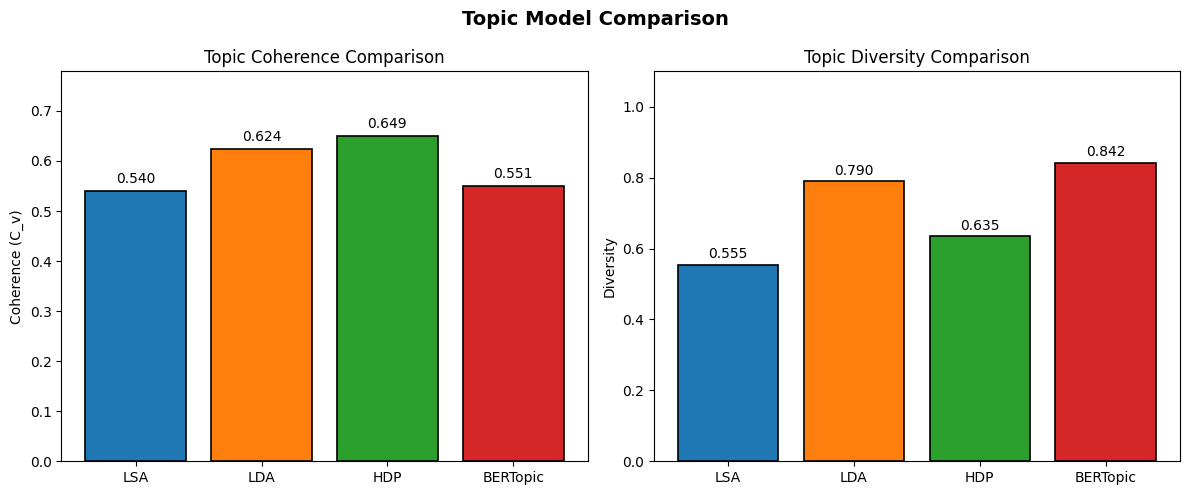

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = list(topic_metrics.keys())
coherence_values = [topic_metrics[m].get('coherence', 0) or 0 for m in models]
diversity_values = [topic_metrics[m].get('diversity', 0) or 0 for m in models]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(models)]

ax1 = axes[0]
bars1 = ax1.bar(models, coherence_values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Coherence (C_v)')
ax1.set_title('Topic Coherence Comparison')
ax1.set_ylim(0, max(coherence_values) * 1.2 if max(coherence_values) > 0 else 1)
for bar, val in zip(bars1, coherence_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

ax2 = axes[1]
bars2 = ax2.bar(models, diversity_values, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Diversity')
ax2.set_title('Topic Diversity Comparison')
ax2.set_ylim(0, 1.1)
for bar, val in zip(bars2, diversity_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Topic Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "topic_metrics_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

In [32]:
if PYLDAVIS_AVAILABLE and lda_model:
    try:
        lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
        pyLDAvis.display(lda_vis)
        pyLDAvis.save_html(lda_vis, os.path.join(PLOTS_DIR, "lda_pyldavis.html"))
        print(f"Saved: {os.path.join(PLOTS_DIR, 'lda_pyldavis.html')}")
    except Exception as e:
        print(f"pyLDAvis error: {e}")

Saved: output\plots\lda_pyldavis.html


In [ ]:
if bertopic_model:

    fig_barchart = bertopic_model.visualize_barchart(top_n_topics=8)
    fig_barchart.write_html(os.path.join(PLOTS_DIR, "bertopic_barchart.html"))
    fig_barchart.show()
    
    fig_topics = bertopic_model.visualize_topics()
    fig_topics.write_html(os.path.join(PLOTS_DIR, "bertopic_topics.html"))
    fig_topics.show()
    
    fig_hierarchy = bertopic_model.visualize_hierarchy()
    fig_hierarchy.write_html(os.path.join(PLOTS_DIR, "bertopic_hierarchy.html"))
    fig_hierarchy.show()

---

# PART 3: RESULTS AND CONCLUSIONS

## 3.1 Final Summary

In [34]:
total_samples = len(df_leakage) + len(df_leakage_test)

# Best models
best_with_leakage = clf_df[clf_df['leakage_prevention'] == 'Yes'].sort_values('f1_weighted', ascending=False).iloc[0]
best_without_leakage = clf_df[clf_df['leakage_prevention'] == 'No'].sort_values('f1_weighted', ascending=False).iloc[0]

print(f"""
================================================================================
                         FINAL SUMMARY
================================================================================

DATASET
  Samples: {total_samples} (Train: {len(df_leakage)}, Test: {len(df_leakage_test)})
  Classes: {len(label_encoder.classes_)}

CLASSIFICATION (Best F1-weighted)
  With Leakage Prevention:    {best_with_leakage['model']} = {best_with_leakage['f1_weighted']:.4f}
  Without Leakage Prevention: {best_without_leakage['model']} = {best_without_leakage['f1_weighted']:.4f}
  Performance Gap: {best_without_leakage['f1_weighted'] - best_with_leakage['f1_weighted']:.4f}

TOPIC MODELING
  Number of topics: {N_TOPICS}
""")

print(topic_df.to_string(index=False))

print("\n" + "="*80)


                         FINAL SUMMARY

DATASET
  Samples: 28130 (Train: 19691, Test: 8439)
  Classes: 615

CLASSIFICATION (Best F1-weighted)
  With Leakage Prevention:    TF-IDF + RF = 0.6583
  Without Leakage Prevention: TF-IDF + RF = 0.6670
  Performance Gap: 0.0087

TOPIC MODELING
  Number of topics: 20

   Model  Coherence  Perplexity  Diversity
     LSA   0.539787         NaN   0.555000
     LDA   0.623583   -8.520199   0.790000
     HDP   0.649286  -14.012723   0.635000
BERTopic   0.550866         NaN   0.842105

